### Clear memory

In [1]:
%reset -f
import gc
gc.collect()

0

### Import

In [2]:
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import sys
from pathlib import Path
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
sns.set_style('whitegrid')
%matplotlib inline

In [3]:
import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=UserWarning)

In [4]:
sys.path.append('..')
from src.data_utils import download_file, load_and_analyze_pdf, create_chunks

# Data Loading
### Choose the document
The common use of RAG is technical PDF documents, e.g. documentation. In this project the Amazons User Guide is chosen. 

In [5]:
PDF_URL = 'https://docs.aws.amazon.com/pdfs/vsts/latest/userguide/vsts-ug.pdf'

Define the name of the saved document 

In [6]:
PDF_NAME = 'aws_vsts.pdf'

Download document 

In [7]:
download_file(url=PDF_URL, name=PDF_NAME, overwrite=False)

File aws_vsts.pdf already exists


# Exploratory Data Analysis

Define the path to the file

In [8]:
PDF_PATH = Path('../data/raw/') / PDF_NAME

### Extract text from PDF 
Use `pymupdf` package to extract all information from provided PDF to dataframe. Also print basic information about document  

In [9]:
df = load_and_analyze_pdf(PDF_PATH)

Extracting pages:   0%|          | 0/118 [00:00<?, ?it/s]

Filename: aws_vsts.pdf
Title: AWS Toolkit for Microsoft Azure DevOps - User Guide
Author: 
Subject: 
File size: 1.30 MB
Number of pages: 118
Total number of chars: 195058

Describe char distribution


count     118.000000
mean     1653.033898
std       875.753907
min        89.000000
25%      1325.250000
50%      1621.500000
75%      1942.750000
max      5605.000000
Name: char_count, dtype: float64

In [10]:
df.head()

,page_num,text,char_count
0,1,User Guide\nAWS Toolkit for Microsoft Azure De...,135
1,2,AWS Toolkit for Microsoft Azure DevOps\nUser G...,587
2,3,AWS Toolkit for Microsoft Azure DevOps\nUser G...,4979
3,4,AWS Toolkit for Microsoft Azure DevOps\nUser G...,5561
4,5,AWS Toolkit for Microsoft Azure DevOps\nUser G...,5605


Print random page text

In [11]:
print(df[df['page_num'] == 28]['text'].values[0])

AWS Toolkit for Microsoft Azure DevOps
User Guide
Conﬁgure the task properties
• AWS Credentials
If you have already conﬁgured AWS credentials for your project, you can select them from the 
drop-down list. If not, you can add credentials for this task by choosing New next to the AWS 
Credentials ﬁeld. For information about ﬁlling out the resulting Add AWS service connection
form, see the section called “Supply task credentials using a service connection”.
This task requires credentials for a user with a policy enabling the user to update an Elastic 
Beanstalk environment and describe an environment's status and events.
Deploying an ASP.NET application using the AWS Elastic Beanstalk Deploy Application task
22



### Plot char distribution 

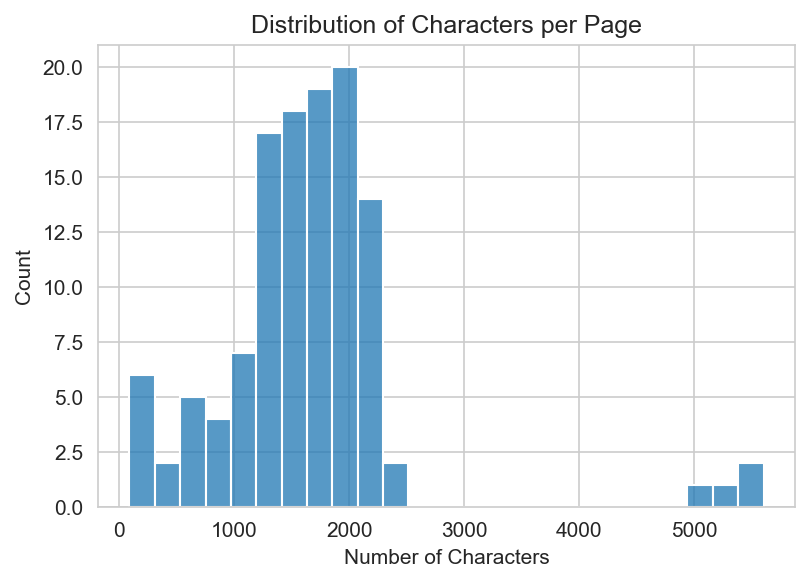

In [12]:
plt.figure(figsize=(6,4), dpi=150)
sns.histplot(data=df, x='char_count', bins=25)
plt.title('Distribution of Characters per Page')
plt.xlabel('Number of Characters')
plt.show()

**Observation:** most pages have 1000-2000 symbols, but there are 4 pages with roughly 5 tausend characters. Overall, distribution is left skewed. 

### Plot text length depends on page

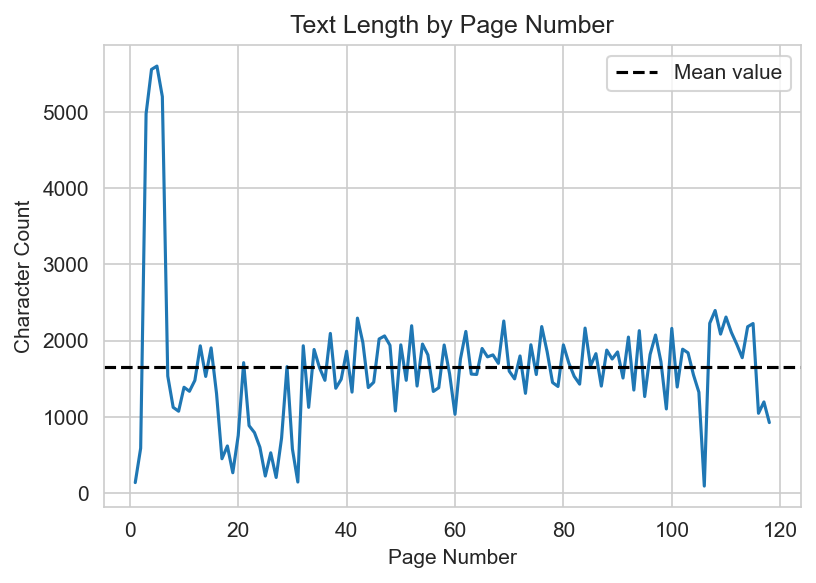

In [13]:
plt.figure(figsize=(6,4), dpi=150)
sns.lineplot(data=df, x='page_num', y='char_count')
plt.axhline(y=df['char_count'].mean(), c='k', linestyle='--', label='Mean value')
plt.title('Text Length by Page Number')
plt.xlabel('Page Number')
plt.ylabel('Character Count')
plt.legend()
plt.show()

**Observation:** most pages have around 1700 characters, but there are 4 pages in the beginning of the document, that have over 5000 chars. 

# Chunking
### Split text into chunks with overlapping
LLMs have limited context window, so it is helpful to split each page into chunks. Each chunk contain text from one page. The maximum chunk size is set to 1000 - this is very common choice. The overlap between chunks within the same page is allowed and set to 200 - also common choice. 

In [14]:
chunks = create_chunks(df, chunk_size=500, overlap=100)

print(f'Number of chunks: {len(chunks)}')

Chunking:   0%|          | 0/118 [00:00<?, ?it/s]

Number of chunks: 569


In [15]:
chunks.head(3)

,chunk_id,text,page_num,char_count,start_char,end_char
0,0,User Guide AWS Toolkit for Microsoft Azure Dev...,1,134,0,134
1,1,AWS Toolkit for Microsoft Azure DevOps User Gu...,2,422,0,422
2,2,"s likely to cause confusion among customers, o...",2,260,322,822


### Plot Chunks Distribution 


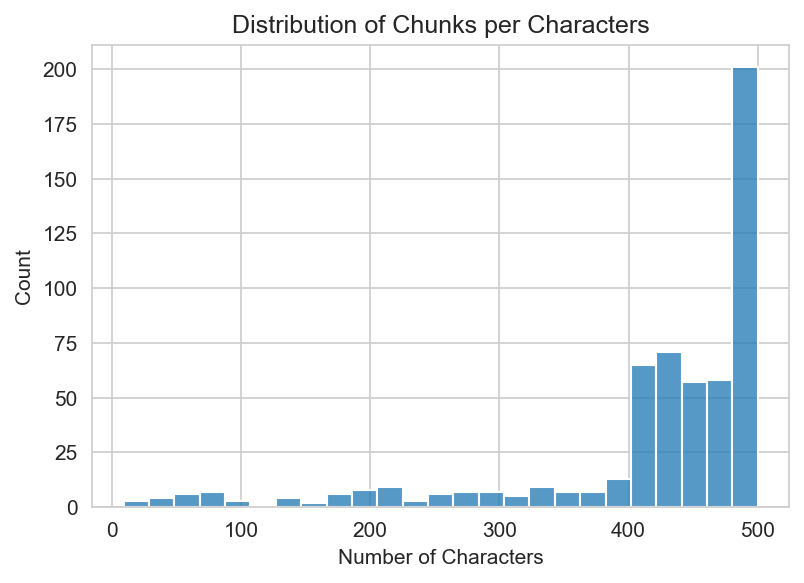

In [16]:
plt.figure(figsize=(6,4), dpi=150)
sns.histplot(data=chunks, x='char_count', bins=25)
plt.title('Distribution of Chunks per Characters')
plt.xlabel('Number of Characters')
plt.show()

**Observation:** the distribution has severe left skewness, most chunks consist of 400-500 chars, but there are some very short chunks. 

### Save chunks to the file for future use

In [17]:
chunks.to_json(
    path_or_buf='../data/processed/chunks.json',
    orient='records',
    force_ascii=False,
    indent=4
)

# Summary
In this notebook, the data for RAG system was prepared:
- AWS technical documentation was downloaded
- Page structure and text distribution were analyzed
- Then pages were split into 500-character overlapping chunks
- The chunks were saved for the next steps, such as embedding creation.